In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_6_1_gaba_normal'

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 10.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400


drawing_size = 25


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'
mpl.rcParams['font.family'] =  ['DejaVu Sans']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'

# print(mpl.rcParams.keys())


In [5]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 4.0 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

In [7]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) #*  1/(np.exp(gaba_exc))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(np.exp(gaba_inh))
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q



# Input

In [49]:

# to simulate that the gaba influence on the inhibitory side is stronger
# gaba_inh = np.linspace(0.0,0.13,5)
# b = 0.05
# a = 60
# gaba_inh = 0.13 / (1 + np.exp(-(gaba_inh-b)*a) )
# gaba_exc = gaba_inh*5


gaba_inh = np.linspace(0.0,0.3,5)
gaba_inh = np.array([0.0,0.10,0.15,0.20,0.25])
gaba_exc = gaba_inh *2.5



# store values for different parameters
q_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))
r_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))

############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(len(gaba_exc)):
    
    l = k 
    ############################################################
    #                       Inputs                             #
    ############################################################
    s_gbc_all= np.zeros((len(t),freq_bands))
    s_sbc_all = np.zeros((len(t),freq_bands))

    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    sigma = 1.0

    ### MNTB inhibitory input (contra-lateral) ###
    gbc_center_frequencyBand =2
    gbc_input_strength = 1.0

    # build ramps
    time_window = 200 # that equals a step of 5dB
    for i in range(0,len(t)-time_window,time_window):
        s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = (i)/(len(t)-time_window) * gbc_input_strength


    # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
    s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')


    # LSO direct excitatory input (ipsi-lateral)
    sbc_center_frequencyBand = 2
    sbc_input_strength = 1.0

    # build ramps
    for i in range(0,len(t)-time_window,time_window):
        s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = (len(t)-time_window-i)/(len(t)-time_window) * sbc_input_strength


    # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
    s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')


    # Convolve with gauss curve to build a temporal ramp
    s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
    s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

    # normalize input
    maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    s_gbc_all /= maxi
    s_sbc_all /= maxi

    # correct for border effect of convolve
    s_gbc_all[-130:,gbc_center_frequencyBand] = np.max(s_gbc_all[-130:])
    s_sbc_all[:130,sbc_center_frequencyBand] = np.max(s_sbc_all[:130])



    for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.6)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)

                delay_factor = 20
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,gaba_exc[l],gaba_inh[k])       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,gaba_exc[l],gaba_inh[k])       

                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)





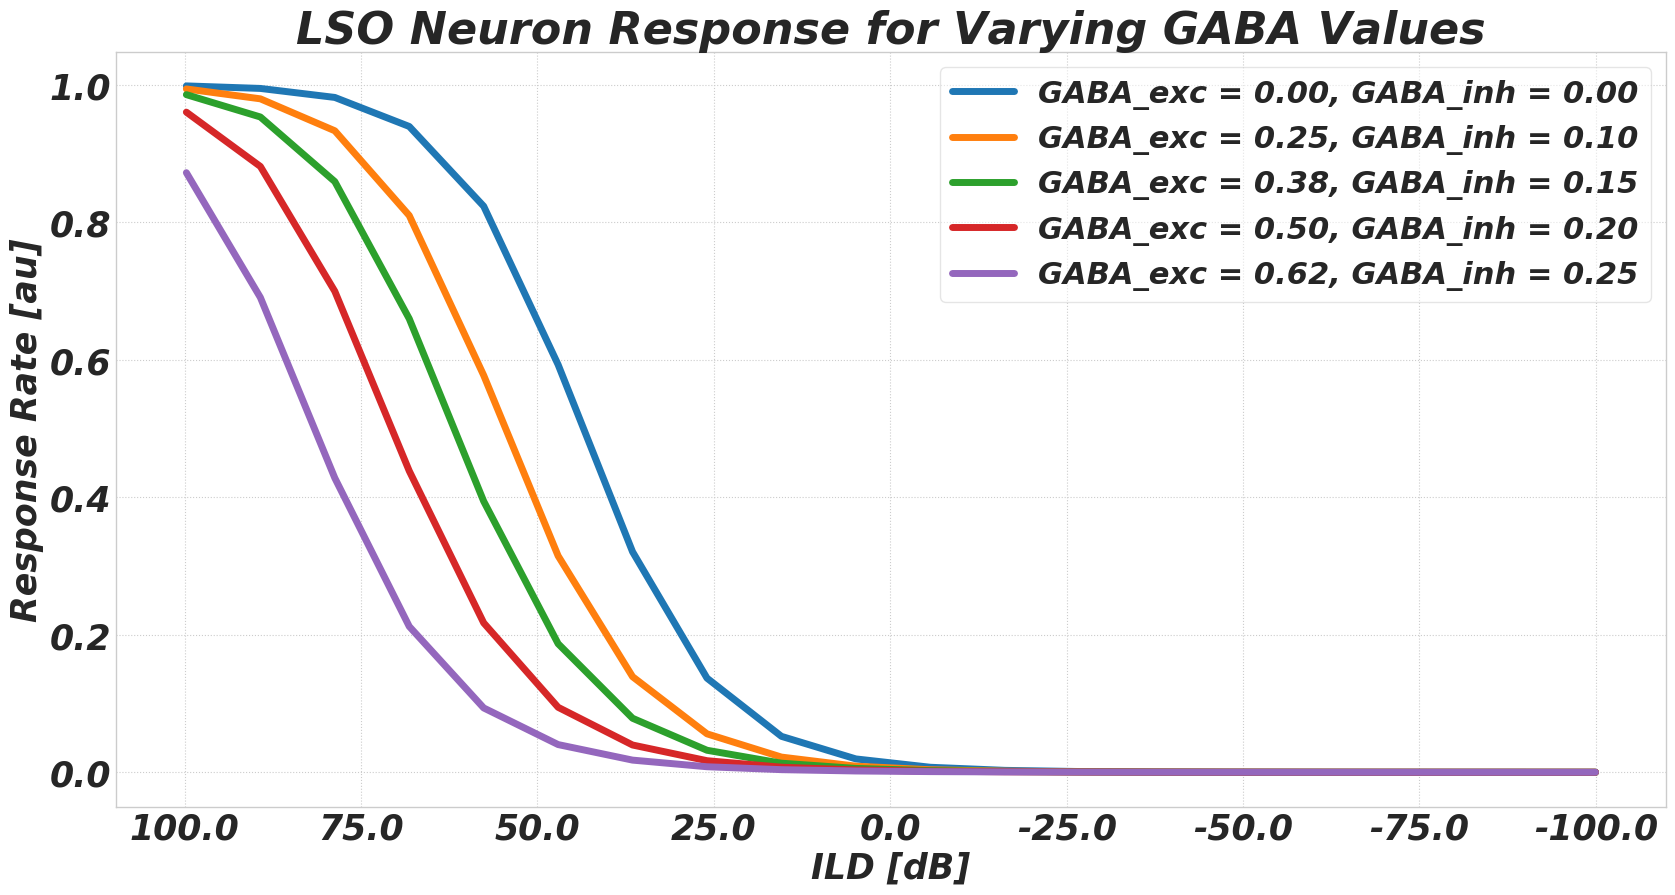

In [50]:
# Define the times when to probe
probing_times = np.arange(130,len(t),time_window)
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
for i in range(0,r.shape[0]):
    j = i
    tmp = g_r_out(r[i,j,probing_times])
    # normalize it
#     tmp = tmp / np.max(tmp)
    ax2.plot(diff_input[probing_times],tmp,linestyle='-',label='GABA_exc = {0:.2f}, GABA_inh = {1:.2f}'.format(gaba_exc[i],gaba_inh[j]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying GABA Values')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
ax2.set_xticklabels(ax2.get_xticks()*100)

lgd = plt.legend()

plt.savefig(figure_name + 'response_shift.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_shift.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




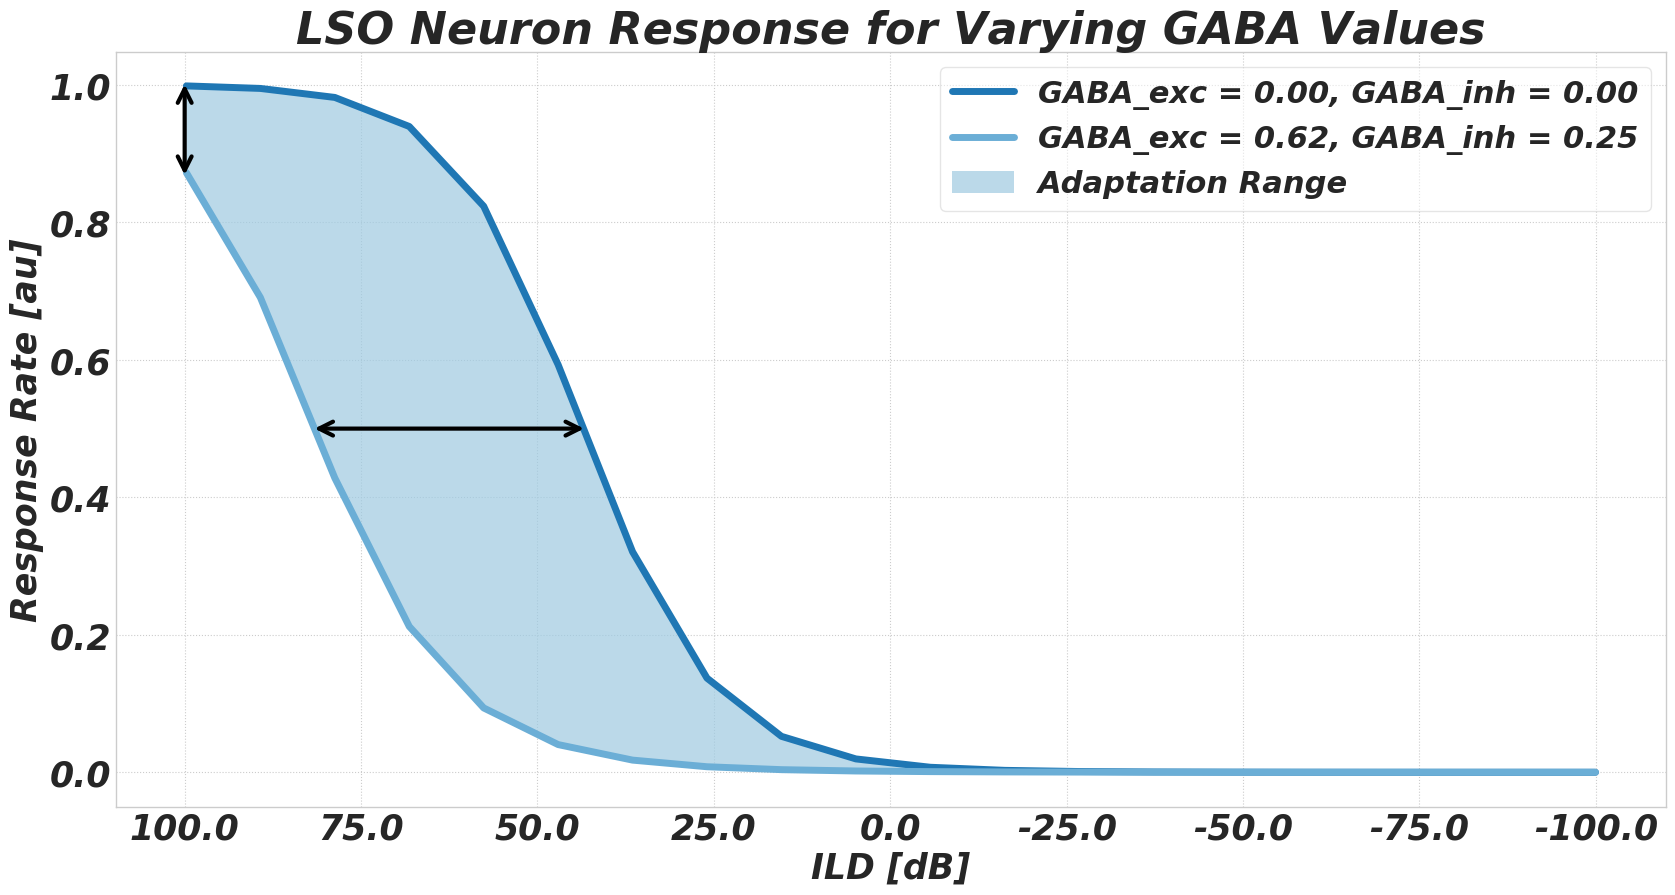

In [56]:
# Define the times when to probe
probing_times = np.arange(130,len(t),time_window)

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
tmp = g_r_out(r[0,0,probing_times])
ax2.plot(diff_input[probing_times],tmp,linestyle='-',label='GABA_exc = {0:.2f}, GABA_inh = {1:.2f}'.format(gaba_exc[0],gaba_inh[0]))

tmp2 = g_r_out(r[-1,-1,probing_times])
ax2.plot(diff_input[probing_times],tmp2,linestyle='-',color='#6baed6',label='GABA_exc = {0:.2f}, GABA_inh = {1:.2f}'.format(gaba_exc[-1],gaba_inh[-1]))

ax2.fill_between(diff_input[probing_times],tmp, tmp2, facecolor='#9ecae1', alpha=0.7,label='Adaptation Range')

ax2.annotate("", xy=(0.82, 0.5), xytext=(0.43, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=3))

ax2.annotate("", xy=(1, 1.005), xytext=(1, 0.865),arrowprops=dict(arrowstyle="<->",linewidth=3))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying GABA Values')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
ax2.set_xticklabels(ax2.get_xticks()*100)

lgd = plt.legend()

plt.savefig(figure_name + 'response_shift_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_shift_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




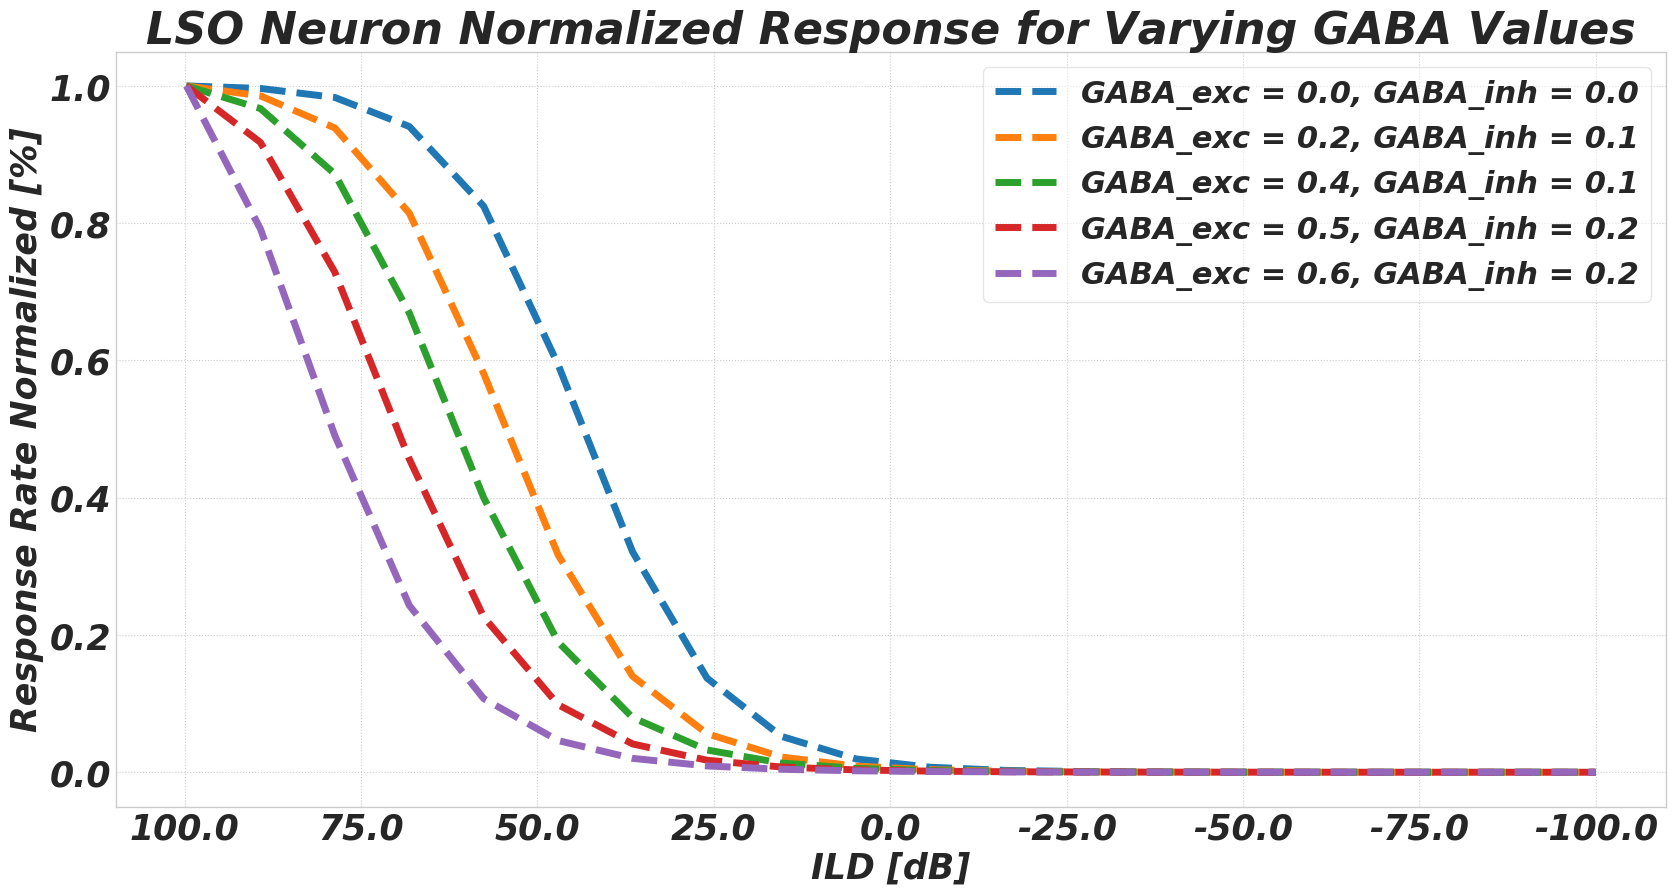

In [54]:
# Define the times when to probe
probing_times = np.arange(130,len(t),time_window)

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
for i in range(len(gaba_exc)):
    j = i
    tmp = g_r_out(r[i,j,probing_times])
    # normalize it
    tmp = tmp -  np.min(tmp)
    tmp = tmp / np.max(tmp)
    ax2.plot(diff_input[probing_times],tmp,linestyle='--',label='GABA_exc = {0:.1f}, GABA_inh = {1:.1f}'.format(gaba_exc[i],gaba_inh[j]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Normalized Response for Varying GABA Values')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate Normalized [%]')
ax2.set_xticklabels(ax2.get_xticks()*100)

lgd = plt.legend()

plt.savefig(figure_name + 'normalized_response_shift.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'normalized_response_shift.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()





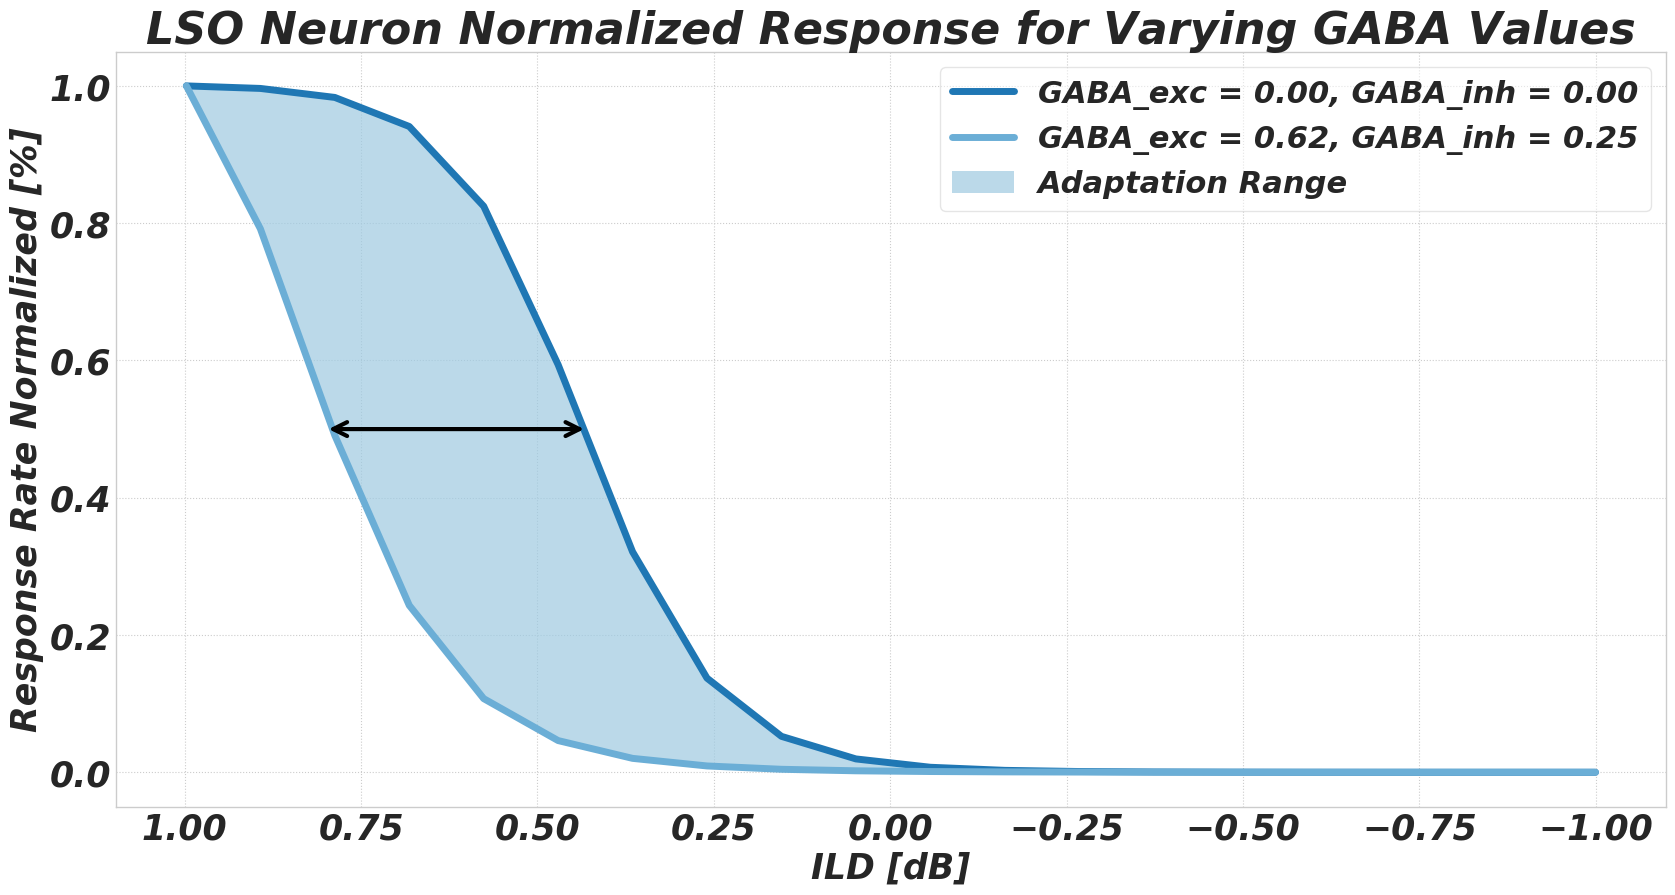

In [59]:
# Define the times when to probe
probing_times = np.arange(130,len(t),time_window)

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
# for i in range(0,10):
#     j = i
#     tmp = g_r_out(r[i,j,probing_times])
#     # normalize it
#     tmp = tmp -  np.min(tmp)
#     tmp = tmp / np.max(tmp)
#     ax2.plot(diff_input[probing_times],tmp,linestyle='--',label='GABA_exc = {0:.1f}, GABA_inh = {1:.1f}'.format(gaba_exc[i],gaba_inh[j]))
    
    
tmp = g_r_out(r[0,0,probing_times])
tmp = tmp -  np.min(tmp)
tmp = tmp / np.max(tmp)

ax2.plot(diff_input[probing_times],tmp,linestyle='-',label='GABA_exc = {0:.2f}, GABA_inh = {1:.2f}'.format(gaba_exc[0],gaba_inh[0]))

tmp2 = g_r_out(r[-1,-1,probing_times])
tmp2 = tmp2 -  np.min(tmp2)
tmp2 = tmp2 / np.max(tmp2)
ax2.plot(diff_input[probing_times],tmp2,linestyle='-',color='#6baed6',label='GABA_exc = {0:.2f}, GABA_inh = {1:.2f}'.format(gaba_exc[-1],gaba_inh[-1]))

ax2.fill_between(diff_input[probing_times],tmp, tmp2, facecolor='#9ecae1', alpha=0.7,label='Adaptation Range')


ax2.annotate("", xy=(0.80, 0.5), xytext=(0.43, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=3))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Normalized Response for Varying GABA Values')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate Normalized [%]')
# ax2.set_xticklabels(ax2.get_xticks()*100)
# ax2.set_yticklabels([int(i*100) for i in ax2.get_yticks()])

lgd = plt.legend()

plt.savefig(figure_name + 'normalized_response_shift_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'normalized_response_shift_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()